-----

# Functional Loggerについて

-----

ogawa 2019.1.19



## Logger Module の狙い

***
### ターゲット
- 柔軟に設計したいユーザー
- シンプルに設計したいユーザー

### 柔軟に設計したいユーザーへのコンセプト
- ロギングのタイミングを自由に
- ロギングしたい変数選択を自由に
- ロギング量を自由に

### シンプルに設計したいユーザーへのコンセプト
- 引数をできるだけ最小限に

イメージ：用途に応じて　functional と sequential と同様の方法で実装してもらう
***

# ノートの狙い

<hr>

Functional Logger モジュールの理解、およびテスト

## ライブラリ
------
- ReNomRL v0.4
- tqdm 4.19.9
- numpy 1.14.0

# アルゴリズム定義
<hr>

DQNと仮定する

In [1]:
from time import sleep
import numpy as np


def try_except(self,func):
    def inner(*args,**kwargs):
        try:
            func(*args,**kwargs)
        finally:
            self.logger.close()
    return inner


def remove_col(self,func):
    def inner(*args,**kwargs):
        return func(*args,**kwargs)[:-2]
    return inner




class DQN(object):
    def __init__(self,logger):
        logger._key_check(["state","reward"])
        self.logger = logger
        self.fit = try_except(self,self.fit)
    
    
    def fit(self):
        self.logger.start(30)

        s,r=0,0
        for i in range(30):
            s += 1
            sleep(0.1)
            r += np.array([np.random.randint(-2,3),np.random.randint(0,6)])
            self.logger.logger(state=s,reward=r)

        self.logger.close()

# Basicテスト
<hr>

## ロガー定義

In [2]:
from renom_rl.utility.logger import Logger
import numpy as np
from copy import copy

class Original(Logger):
    def __init__(self,log_key):
        super(Original,self).__init__(log_key)
        self.reward_previous = 0
        self.reward = 0
        self.total_list = []
        self.state = 0
        self.total = 0
    
    def logger(self,**log):
        self.state = copy(log["state"])
        self.reward = copy(log["reward"])
        
        flag = np.sum(self.reward - self.reward_previous)*np.random.randint(-1,2)
        
        self.total += flag if flag>=0 else 0
        
        if flag:
            self.total_list.append(self.reward)
        
        self.reward_previous = self.reward
        
        if flag:
            return "state----{}/reward---{}/total----{}".format(self.reward , self.state, flag)
        else:
            return "minus"

## インスタンス

In [3]:
originalLogger=Original(["reward"])

## 実行

In [4]:
dqn=DQN(originalLogger)
dqn.fit()

state----[-3 71]/reward---30/total-----2: 100%|██████████| 30/30 [00:03<00:00,  9.44it/s]


In [5]:
# originalLogger.result()

## グラフ

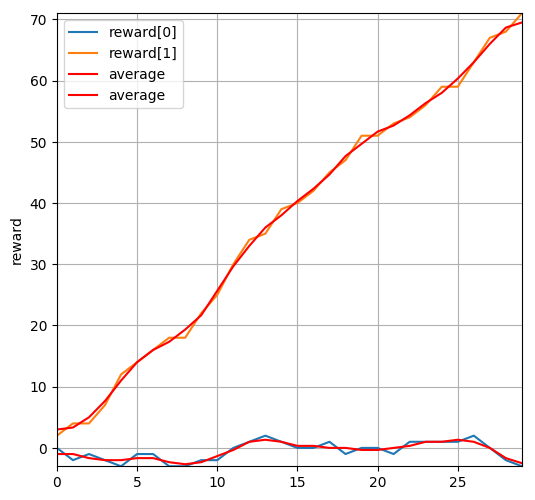

In [6]:
originalLogger.graph(y_key="reward",
             figsize=(6,6),dpi=100,average_range=1)

## CSV書込

In [7]:
originalLogger.to_csv("./test_csv_2.csv")

## リセット

In [8]:
originalLogger.reset()
originalLogger.result()

{'reward': []}

## 読込

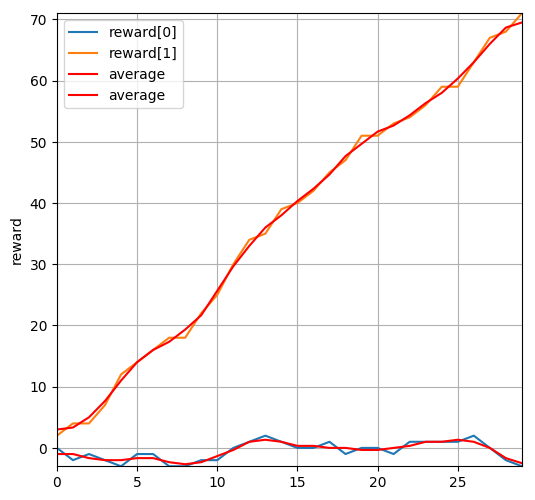

In [9]:
originalLogger.reset()
originalLogger.from_csv("./test_csv_2.csv")
originalLogger.graph(y_key="reward",figsize=(6,6), dpi=100,average_range=1)

# カスタムテスト
<hr>

## graph_custom

In [10]:
array_list=np.array(originalLogger.total_list)[:,1]
print(array_list)

[ 2  4  7 12 14 16 39 45 53 59 63 68 71]


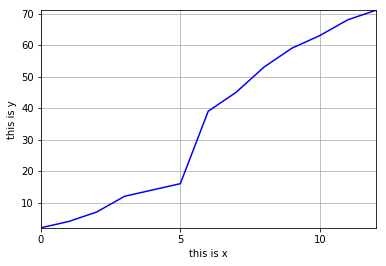

In [11]:
originalLogger.graph_custom(array_list,y_label="this is y",x_label="this is x",x_interval=5)

## forget constructor

In [12]:
class OriginalFail(Logger):
    def __init__(self,log_key):
        # super(OriginalFail,self).__init__(log_key)
        pass
    
    def logger(self,**log):
        pass

try:
    fail=OriginalFail(["self"])

except NotImplementedError as e:
    print(e)

Need to call super('class',self).__init__(log_key,record=True)  ('class':Class Name.)


## key board interupt

In [13]:
class OriginalFail(Logger):
    def __init__(self):
        super(OriginalFail,self).__init__([])
        self.i=0
        self.raise_flag=True
        
    def logger(self,**log):
        self.i += 1 
        if self.raise_flag:
            if self.i> 10:
                raise Exception("break")

            
faillogger=OriginalFail()
dqn=DQN(faillogger)

try:    
    dqn.fit()
    
except Exception as e:
    print(e)

faillogger.raise_flag=False
dqn.fit()

  3%|▎         | 1/30 [00:00<00:03,  9.61it/s]

break


100%|██████████| 30/30 [00:03<00:00,  9.85it/s]


# その他
<hr>

## Simple Logger テスト書参照